# Градиентный бустинг

In [19]:
import pandas as pd
import numpy as np

from sklearn import ensemble, tree, linear_model, model_selection, metrics 
from sklearn.model_selection import learning_curve, cross_val_score, train_test_split

import numpy as np
import pandas as pd
import xgboost as xgb
import catboost
import lightgbm as lgbm

import warnings
warnings.filterwarnings('ignore')

Бустинг это метод построения компизиции алгоритмов, в котором базовые алгоритмы строятся последовательно один за другим, причем каждый следующий алгоритм строится таким образом, чтобы уменьшить ошибку предыдущего.

Положим, что алгоритм это линейная комбинация некоторых базовых алгоритмов:
    $$a_N(x) = \sum_{n=1}^N b_n(x)$$

Пусть задана некоторая функция потетерь, которую мы оптимизируем
$$\sum_{i=1}^l L(\hat y_i, y_i) \rightarrow min$$ 


Зададимся вопросом: а что если мы хотим добавить ещё один алгоритм в эту композицию, но не просто добавить, а как можно оптимальнее с точки зрения исходной оптимизационной задачи. То есть уже есть какой-то алгоритм $a_N(x)$ и мы хотим прибавить к нему базовый алгоритм $b_{N+1}(x)$:

$$\sum_{i=1}^l L(a_{N}(x_i) + b_{N+1}(x_i), y_i) \to \min_{b_{N+1}}$$

Сначала имеет смысл решить более простую задачу: определить, какие значения $r_1 ,r_2 ..., r_l$ должен принимать алгоритм $b_N(x_i) = r_i$ на объектах обучающей выборки, чтобы ошибка на обучающей выборке была минимальной:

$$F(r) = \sum_{i=1}^l L(a_{N}(x_i) + r_i, y_i) \to \min_{r},$$

где $r = (r_1, r_2, \dots, r_l)$ - вектор сдвигов.

Поскольку направление наискорейшего убывания функции задается направлением антиградиента, его можно принять в качестве вектора $r$:
$$r = -\nabla F \\$$
$$r_i = \frac{\partial{L}(a_N(x_i), y_i))}{\partial{a_N(x_i)}}, \ \ \ i = \overline{1,l}$$

Компоненты вектора $r$, фактически, являются теми значениями, которые на объектах обучающей выборки должен принимать новый алгоритм $b_{N+1}(x)$, чтобы минимизировать ошибку строящейся композиции. 
Обучение $b_{N+1}(x)$, таким образом, представляет собой *задачу обучения на размеченных данных*, в которой ${(x_i , r_i )}_{i=1}^l$ — обучающая выборка, и используется, например, квадратичная функция ошибки:
$$b_{N+1}(x) = arg \min_{b}\sum_{i=1}^l(b(x_i) - r_i)^2$$

Таким образом, можно подобрать неплохое улучшение текущего алгоритма $a_N(x)$, а потом ещё раз и ещё, в итоге получив комбинацию алгоритмов, которая будет минимизировать исходный функционал.

# Бустинг над решающими деревьями

Наиболее популярное семейство алгоритмов для бустинга это деревья. Рассмотрим популярные библиотеки

In [3]:
data = pd.read_csv('hr_kaggle.csv')

In [4]:
X, y = data.drop('left', axis=1).values, data['left'].values

Качество классификации решающим деревом с настройками по-умолчанию:

In [6]:
%%time
print("XGBClassifier: {:.4f}".format(cross_val_score(xgb.XGBClassifier(), X, y).mean()))

XGBClassifier: 0.7791
CPU times: user 612 ms, sys: 2.86 ms, total: 614 ms
Wall time: 616 ms


In [8]:
%%time
print("CatBoostClassifier: {:.4f}".format(cross_val_score(catboost.CatBoostClassifier(verbose=False), X, y).mean()))

CatBoostClassifier: 0.7778
CPU times: user 2min 54s, sys: 41.3 s, total: 3min 35s
Wall time: 20 s


In [9]:
%%time
print("LGBMClassifier: {:.4f}".format(cross_val_score(lgbm.LGBMClassifier(), X, y).mean()))

LGBMClassifier: 0.7790
CPU times: user 299 ms, sys: 0 ns, total: 299 ms
Wall time: 298 ms


## Зависимость качества от количества деревьев

In [10]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### RandomForestClassifier

In [11]:
n_trees = [1] + list(range(5, 55, 5))

In [12]:
%%time
scoring = []
for n_tree in n_trees:
    estimator = ensemble.RandomForestClassifier(n_estimators = n_tree, min_samples_split=5, random_state=1)
    score = model_selection.cross_val_score(
        estimator, X, y, 
        scoring = 'accuracy', cv = 3
    )    
    scoring.append(score)
scoring = np.asmatrix(scoring)

CPU times: user 5.04 s, sys: 7.39 ms, total: 5.05 s
Wall time: 5.06 s


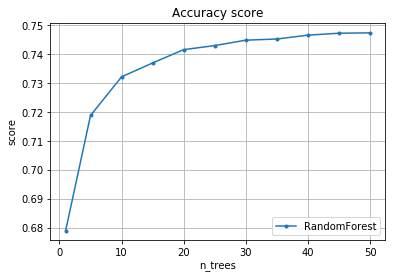

In [13]:
pylab.plot(n_trees, scoring.mean(axis = 1), marker='.', label='RandomForest')
pylab.grid(True)
pylab.xlabel('n_trees')
pylab.ylabel('score')
pylab.title('Accuracy score')
pylab.legend(loc='lower right');

### XGBoost

In [14]:
%%time
xgb_scoring = []
for n_tree in n_trees:
    estimator = xgb.XGBClassifier(learning_rate=0.1, max_depth=6, n_estimators=n_tree)
    score = model_selection.cross_val_score(
        estimator, X, y,
        scoring = 'accuracy', cv = 3
    )    
    xgb_scoring.append(score)
xgb_scoring = np.asmatrix(xgb_scoring)

CPU times: user 3.38 s, sys: 0 ns, total: 3.38 s
Wall time: 3.38 s


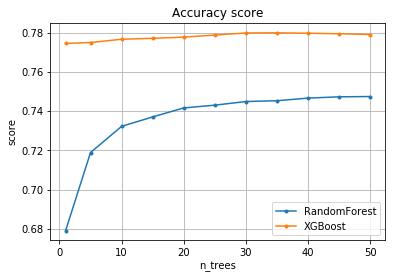

In [15]:
pylab.plot(n_trees, scoring.mean(axis = 1), marker='.', label='RandomForest')
pylab.plot(n_trees, xgb_scoring.mean(axis = 1), marker='.', label='XGBoost')
pylab.grid(True)
pylab.xlabel('n_trees')
pylab.ylabel('score')
pylab.title('Accuracy score')
pylab.legend(loc='lower right')

#### **Материалы по xgboost:**
python api: http://xgboost.readthedocs.org/en/latest/python/python_api.html

### Catboost

In [16]:
%%time
catboost_scoring = []
for n_tree in n_trees:
    estimator = catboost.CatBoostClassifier(max_depth=6, n_estimators=n_tree, verbose=False)
    score = model_selection.cross_val_score(
        estimator, X, y,
        scoring = 'accuracy', cv=3
    ) 
    catboost_scoring.append(score)
catboost_scoring = np.asmatrix(catboost_scoring)

CPU times: user 57.6 s, sys: 13.8 s, total: 1min 11s
Wall time: 7.04 s


#### **Материалы по Catboost:**
python api: https://tech.yandex.com/catboost/doc/dg/concepts/python-quickstart-docpage/

### LightGMB

In [17]:
%%time
lgbm_scoring = []
for n_tree in n_trees:
    estimator = lgbm.LGBMClassifier(learning_rate=0.5, max_depth=6, n_estimators=n_tree)
    score = model_selection.cross_val_score(
        estimator, X, y,
        scoring='accuracy', cv=3
    )    
    lgbm_scoring.append(score)
lgbm_scoring = np.asmatrix(lgbm_scoring)

CPU times: user 1.17 s, sys: 0 ns, total: 1.17 s
Wall time: 1.16 s


#### **Материалы по LightGMB:**
https://lightgbm.readthedocs.io/en/latest/Python-API.html#scikit-learn-api

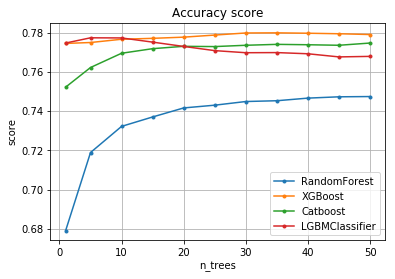

In [18]:
pylab.plot(n_trees, scoring.mean(axis=1), marker='.', label='RandomForest')
pylab.plot(n_trees, xgb_scoring.mean(axis=1), marker='.', label='XGBoost')
pylab.plot(n_trees, catboost_scoring.mean(axis=1), marker='.', label='Catboost')
pylab.plot(n_trees, lgbm_scoring.mean(axis=1), marker='.', label='LGBMClassifier')
pylab.grid(True)
pylab.xlabel('n_trees')
pylab.ylabel('score')
pylab.title('Accuracy score')
pylab.legend(loc='lower right');

# Бустинг и Бэггинг в терминах Bias и Variance

Пусть у нас есть алгоритм обучения, который по данным может создать модель.

Ошибка этих моделей может быть разложена на три части:
* **Noise** – шум данных, не предсказуем, теоретический минимум ошибки
* **Bias** – смещение, на сколько хорошо работает средний алгоритм
* **Variance** – разброс, насколько устойчиво работает алгоритм

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [21]:
def sample_model(seed, model):
    random_gen = np.random.RandomState(seed)
    indices = random_gen.choice(len(y_train), size=len(y_train), replace=True)
    model.fit(X_train[indices, :], y_train[indices])
    return model

def estimate_bias_variance(model, iters_count=100):
    y_preds = []
    for seed in range(iters_count):
        model = sample_model(seed, model)
        y_preds.append(model.predict(X_test))
    y_preds = np.array(y_preds)
    
    print('Bias:', np.mean((y_test - y_preds.mean(axis=0)) ** 2))
    print('Variance:', y_preds.std(axis=0).mean())

**Линейная регрессия**

In [22]:
estimate_bias_variance(linear_model.LinearRegression())

Bias: 0.22186332336126544
Variance: 0.010839374946804628


**Решающее дерево**

In [23]:
estimate_bias_variance(tree.DecisionTreeRegressor(max_depth=5))

Bias: 0.17086085640559948
Variance: 0.04156555236700215


In [24]:
estimate_bias_variance(tree.DecisionTreeRegressor(max_depth=10))

Bias: 0.16986369062123832
Variance: 0.1175690728446637


In [25]:
estimate_bias_variance(tree.DecisionTreeRegressor(max_depth=15))

Bias: 0.17725181005877577
Variance: 0.22245831725080442


In [26]:
estimate_bias_variance(tree.DecisionTreeRegressor(max_depth=None))

Bias: 0.20436392317767715
Variance: 0.32305240377681016


**Случайный лес**

In [28]:
estimate_bias_variance(ensemble.RandomForestRegressor(n_estimators=1, random_state=42))

Bias: 0.1936238162083059
Variance: 0.35427309731542433


In [29]:
estimate_bias_variance(ensemble.RandomForestRegressor(n_estimators=10, random_state=42))

Bias: 0.19157626075396966
Variance: 0.1701656043452099


In [30]:
estimate_bias_variance(ensemble.RandomForestRegressor(n_estimators=50, random_state=42))

Bias: 0.19153034342364533
Variance: 0.14026598763246675


**XGBRegressor**

In [32]:
estimate_bias_variance(xgb.XGBRegressor(n_estimators=1, max_depth=20))

Bias: 0.23488121214913993
Variance: 0.02316007


In [33]:
estimate_bias_variance(xgb.XGBRegressor(n_estimators=1, max_depth=10))

Bias: 0.23438981332791034
Variance: 0.010755043


In [34]:
estimate_bias_variance(xgb.XGBRegressor(n_estimators=1, max_depth=5))

Bias: 0.23508739699808662
Variance: 0.0040729917


In [35]:
estimate_bias_variance(xgb.XGBRegressor(n_estimators=10, max_depth=5))

Bias: 0.1796160550793821
Variance: 0.018256295


In [36]:
estimate_bias_variance(xgb.XGBRegressor(n_estimators=100, max_depth=5))

Bias: 0.170372798305174
Variance: 0.055278454


**CatBoostRegressor**

In [37]:
estimate_bias_variance(catboost.CatBoostRegressor(n_estimators=1, max_depth=6, verbose=False))

Bias: 0.3365919479016018
Variance: 0.00134651371333363


In [38]:
estimate_bias_variance(catboost.CatBoostRegressor(n_estimators=10, max_depth=6, verbose=False))

Bias: 0.2711054484199687
Variance: 0.005561412958879523


In [23]:
estimate_bias_variance(catboost.CatBoostRegressor(n_estimators=100, max_depth=6, verbose=False))

Bias: 0.17608858395709903
Variance: 0.019651480967338052


**LGBMRegressor**

In [40]:
estimate_bias_variance(lgbm.LGBMRegressor(n_estimators=1, max_depth=5))

Bias: 0.21612591960397046
Variance: 0.00652571399354336


In [41]:
estimate_bias_variance(lgbm.LGBMRegressor(n_estimators=10, max_depth=5))

Bias: 0.17735020951803976
Variance: 0.019546488752595192


In [42]:
estimate_bias_variance(lgbm.LGBMRegressor(n_estimators=100, max_depth=5))

Bias: 0.17056450975776588
Variance: 0.05398046618825888
